    # scanpath time dynamics


In [1]:
# imports

import numpy as np
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d01_data.fetch.fetch_fixations import fetch_fixations
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.fixations.FixAlgos import *
from src.d03_processing.feature_calculate.viewing_compare_calcs import ea_td
from src.d03_processing.feature_calculate.transition_calculations import *
from src.d04_wrangling.add_ppt_info import get_ppts_by_group
from src.d03_processing.feature_calculate.fix_sacc_calculations import n_fix, dwell_time

In [7]:
# space for functions
# plot functions
def on_off_plot(tps, cols, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    # multipliers = list(range(1, len(cols) + 1))
    adders = [float(i) * 1.5 for i in range(len(cols))]
    t = tps.eye_timestamp_ms.to_numpy() 
    print(tps.viewing_id[0])
    t = t - t[0]
    colors = itertools.cycle(["r", "b", "g", "c", "m"])
    
    for i in range(len(cols)):
        y = np.array(tps[cols[i]].to_numpy(), dtype=float)
        y += float(adders[i])
        ax.plot(t, y, color=next(colors))
    
    ax.set_yticks(adders, cols)
    
def get_center(obj, tps, y_adjust=0,  trial=None, preshift_postshift=None):
    # display(tps.iloc[:2, :].style)
    in_trial = False
    center = None
    if trial is not None:
        for i in range(1, 5):
            col = f"obj{i}_name"
            if trial[col].to_numpy()[0] == obj:
                center = (trial[f"obj{i}_{preshift_postshift}_x"][0],
                          trial[f"obj{i}_{preshift_postshift}_z"][0],
                          0.7 + y_adjust)
                in_trial = True
    if in_trial is False:
        row = tps[tps.gaze_object == obj].reset_index(drop=True).iloc[0, :]
        center = (row.object_position_x, row.object_position_z, row.object_position_y + y_adjust)

    # print(f"{obj}: {row.gaze_object} {center}")
    return center


def viewing_plot(tps, array_objects=None, gp_lab='table', gp_line=False, ax=None, alpha=0.5, trial=None, preshift_postshift=None,
                 prob_map=None, pmap_voxel_centers=None, title=None):
    
    if tps is not None:
        viewing_id = tps.reset_index(drop=True).viewing_id[0]
    else:
        viewing_id = 'unknown'
        object_positions = []

    if trial is not None:
        trial = trial.reset_index(drop=True)
        

    if array_objects is None:
        if tps is not None:
            full_objects = np.unique(tps.gaze_object)
        else:
            full_objects = []
        if trial is not None:
            for i in range(1, 5):
                col = f"obj{i}_name"
                obj = trial[col][0]
                if obj not in full_objects:
                    full_objects = np.append(full_objects, obj)
        # array_objects = TaskObjects.array_and_invisible
        table_objects = ['InvisibleObject', *TaskObjects.array_objects]
        array_objects = full_objects[np.isin(full_objects,np.array(table_objects))]



        # print(array_objects)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    if tps is not None:
        camera_pos = np.array([np.nanmean(tps.camera_x), np.nanmean(tps.camera_z), np.nanmean(tps.camera_y)])
    else:
        camera_pos = None

    # plot gaze points as points, unless heatmap
    if prob_map is None and tps is not None:
        x, y, z = tps.gaze_collision_x.to_numpy(),tps.gaze_collision_y.to_numpy(),tps.gaze_collision_z.to_numpy()
        lab = tps.gaze_object == 'Table' if gp_lab=='table' else np.array(tps[gp_lab].to_numpy(), dtype=bool)
        no_lab = np.invert(lab)
        # print(lab)
        # print(no_lab)
        ax.scatter(x[lab], z[lab], y[lab], c='red', s=2, alpha=1)
        ax.scatter(x[no_lab], z[no_lab], y[no_lab], c='g', s=2, alpha=alpha)
        if gp_line:
            ax.plot(x, z, y, c='k', linewidth=0.4, alpha=alpha)

    # draw a cylinder to represent a table
    table_y_scale =  0.06538646
    if tps is not None:
        table_center =  get_center('Table', tps) # center of the cylinder
        camera_vec = table_center - camera_pos
    else:
        table_center = (trial.table_location_x[0], trial.table_location_z[0], 0.6346134) 
        camera_vec = None
        
    # print(f"table: {table_center}")
    radius = 0.55  # radius of the cylinder
    height = table_y_scale * 2  # height of the cylinder
    resolution = 20

    # Create the cylinder mesh
    z = np.linspace(table_center[2]-height/2, table_center[2]+height/2, resolution)
    theta = np.linspace(0, 2*np.pi, resolution)
    theta_grid, z_grid = np.meshgrid(theta, z)
    print(table_center)
    x_grid = radius*np.cos(theta_grid) + table_center[0]
    y_grid = radius*np.sin(theta_grid) + table_center[1]

    # Create the Poly3DCollection
    verts = []
    for i in range(len(z)-1):
        verts += [list(zip(x_grid[i], y_grid[i], z_grid[i])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i+1])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i])),
                  list(zip(x_grid[i], y_grid[i], z_grid[i+1]))]
    table = Poly3DCollection(verts, facecolors=[1, 1, 1, 0], edgecolors=[0, 0, 0, 0.2], alpha=0.0)
    table.set_zsort('min')
    ax.add_collection3d(table)

    for obj in array_objects:
        sphere_center = get_center(obj, tps, trial=trial, preshift_postshift=preshift_postshift)
        sphere_radius = 0.12 if obj == 'InvisibleObject' or camera_pos is None else collision_sphere_radius(sphere_center, camera_pos)
        sphere_center = get_center(obj, tps, y_adjust=sphere_radius, trial=trial, preshift_postshift=preshift_postshift)
        # print(f"{obj}: {sphere_center}")
        # sphere_center = get_center(obj, tps)
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + sphere_center[0]
        y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + sphere_center[1]
        z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + sphere_center[2]
        c = [0, 0.8, 0.8, 0.5] if obj == 'InvisibleObject' else [0, 0, 1, 0.5]
        sphere = ax.plot_surface(x, y, z, color=c, alpha=0.05)
        sphere.set_edgecolor(c)
    


    # set axis limits and labels
    ax_len = 0.55
    ax.set_xlim([table_center[0]-ax_len, table_center[0]+ax_len])
    ax.set_ylim([table_center[1]-ax_len, table_center[1]+ax_len])
    ax.set_zlim([table_center[2]-ax_len, table_center[2]+ax_len])
    ax.grid(False)
    if title is None:
        ax.set_title(f'3D model of {viewing_id} viewing')
    else:
        ax.set_title(title, fontsize=10)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()
    
    if camera_vec is not None:
        # set view by average camera position
        azimuthal_angle = 180 + (np.arctan2(camera_vec[1], camera_vec[0]) * 180 / np.pi)
        polar_angle = 180 - (np.arccos(camera_vec[2] / np.linalg.norm(camera_vec)) * 180 / np.pi)
        # Convert angles to radians
        azimuthal_angle_rad = np.deg2rad(azimuthal_angle)
        polar_angle_rad = np.deg2rad(polar_angle)
        # print(f'elev: {polar_angle}, azim: {azimuthal_angle}')
        ax.view_init(elev=polar_angle, azim=azimuthal_angle)

    # add probability map
    if prob_map is not None:
        plot_3d_probability_distribution(prob_map, pmap_voxel_centers,
                                         heatmap_translate=[table_center[0], 0.7, table_center[1]],
                                         ax=ax)


def fixation_plot(fix_df, tps=None, trial=None, fix_range='default', ax=None, gp_lab='fixation', title=None):
    fix_df = fix_df.reset_index(drop=True).sort_values(by='start_time')
    if trial is not None:
        objects = None
    elif tps is not None:
        full_objects = np.unique(tps.gaze_object)
        # array_objects = TaskObjects.array_and_invisible
        array_objects = ['InvisibleObject', *TaskObjects.array_objects]
        objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    else:
        full_objects = np.unique(fix_df.object)
        array_objects = ['InvisibleObject', *TaskObjects.array_objects]
        objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    # print(fix_df.viewing_id[0])
    preshiftpostshift = 'preshift' if 'enc' in fix_df.viewing_id[0] else 'postshift'
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    viewing_plot(tps, objects, gp_lab=gp_lab, gp_line=False, trial=trial, ax=ax, alpha=0.2, preshift_postshift=preshiftpostshift, title=title)
    fixations = fix_df[fix_df.fixation_or_saccade=='fixation'].reset_index(drop=True)
    size_scaler = 1
    arrow_len = 0.75
    start_fix = 0 if fix_range == 'default' else fix_range[0]
    end_fix = len(fixations) if fix_range == 'default' else fix_range[1]
    for i in range(start_fix, end_fix):
        s = size_scaler * fixations.duration_time[i]
        x, y, z = (fixations.centroid_x[i], fixations.centroid_z[i], fixations.centroid_y[i])
        ax.scatter(x, y, z, c='green', s=s, alpha=0.4)
        ax.text(x, y, z, i, color='green')
        if i > 0:
            prev_x, prev_y, prev_z = (fixations.centroid_x[i-1], fixations.centroid_z[i-1], fixations.centroid_y[i-1])
            ax.quiver(prev_x, prev_y, prev_z, 
                      arrow_len*(x-prev_x), arrow_len*(y-prev_y), arrow_len*(z-prev_z), 
                      color='green', alpha=0.4, linewidth=1)
    ax.plot(fixations.centroid_x[start_fix:end_fix], 
            fixations.centroid_z[start_fix:end_fix], 
            fixations.centroid_y[start_fix:end_fix], 'g-', linewidth=1, alpha=0.4)
    

In [3]:
# get data
pids_dict = get_ppts_by_group()
young_pids = pids_dict['Younger']
old_pids = pids_dict['Older']
mci_pids = pids_dict['MCI+']
cutoff = 7000   # ms
pid_groups = [young_pids, old_pids, mci_pids]
group_names = ['Younger', 'Older', 'MCI']
time_bin_size = 1000 # ms
n_bins = int((cutoff / time_bin_size )) + 1
viewing_type = 'ret'

In [4]:
def refixations_only(ext_fix_df):
    ext_fix_df['PrevFixations'] = ext_fix_df.groupby(['object']).cumcount()
    df_refixations = ext_fix_df[ext_fix_df['PrevFixations'] > 0]
    return df_refixations

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = np.abs(array) # Values must be sorted:
    array.sort() # Index per array element:
    index = np.arange(1,array.shape[0]+1) # Number of array elements:
    n = array.shape[0]
    # Gini coefficient calculation:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

# Let's assume these are your data:
observed_counts = np.array([0.5, 0.1, 0.5, 0.1, 0.1, 0.0])

gini_coefficient = gini(observed_counts)
# print("Gini Coefficient: ", gini_coefficient)

# refix = refixations_only(ext_fix)
# display(refix.style)

Gini Coefficient:  0.47435897435897434


MCI *****************************************************************
alloeye_50
- dataframe returned in 0.1117250919342041
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


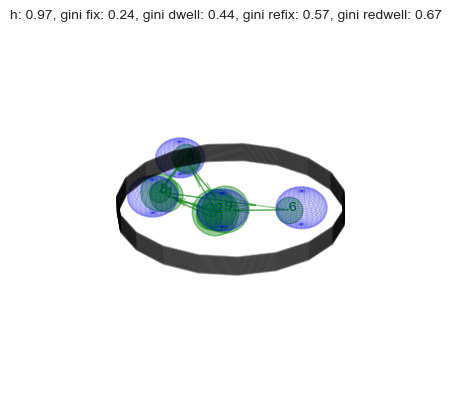

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


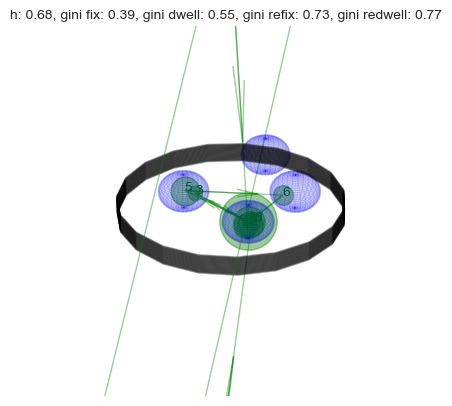

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


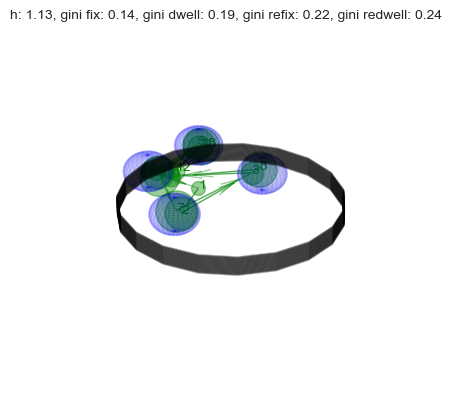

n valid trials 60
alloeye_51
- dataframe returned in 0.17852282524108887
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


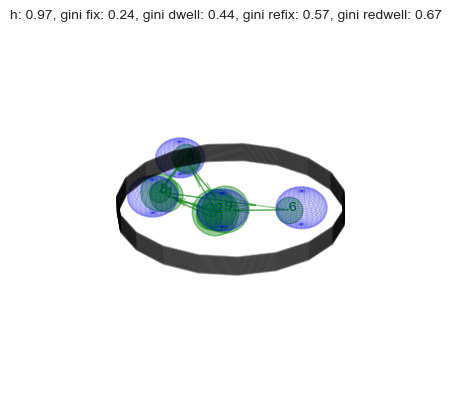

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


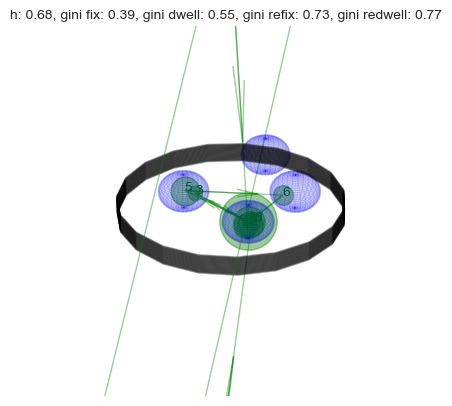

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


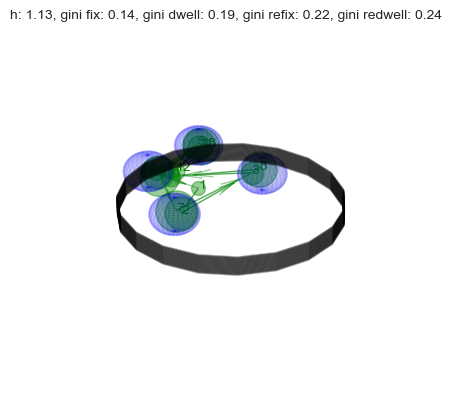

n valid trials 60
alloeye_52
- dataframe returned in 0.11079597473144531
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


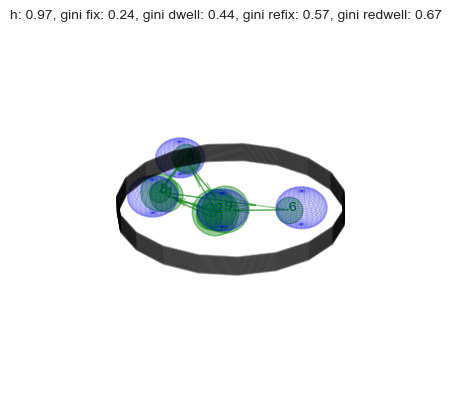

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


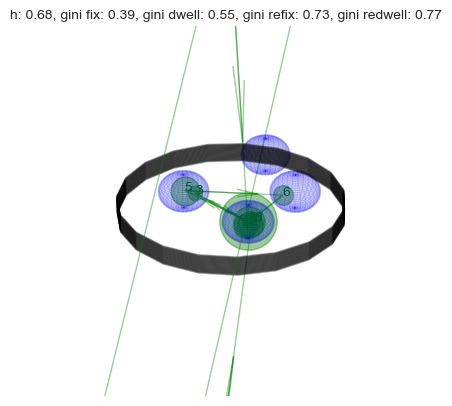

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


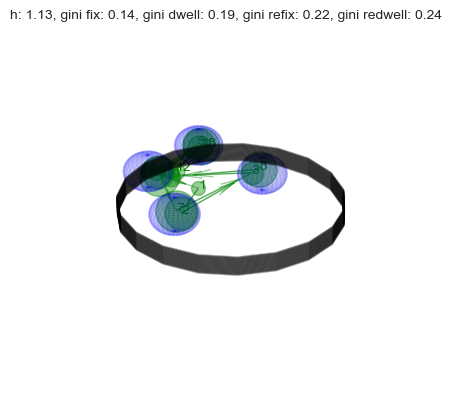

n valid trials 60
MCI *****************************************************************
alloeye_50
- dataframe returned in 0.11070370674133301
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


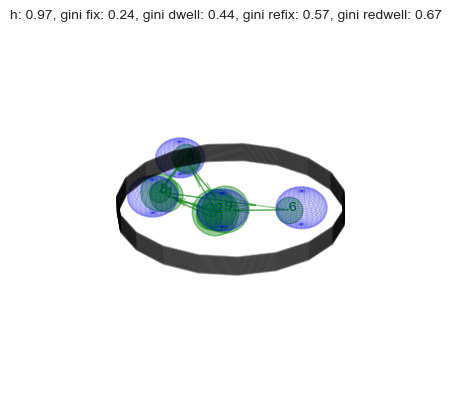

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


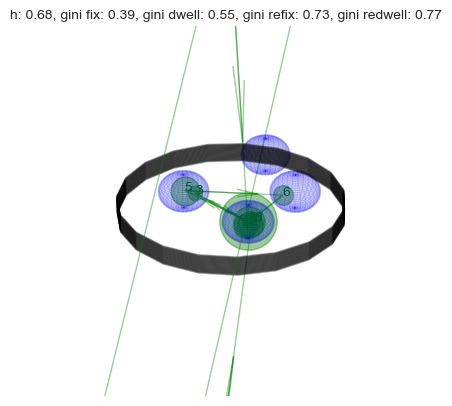

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


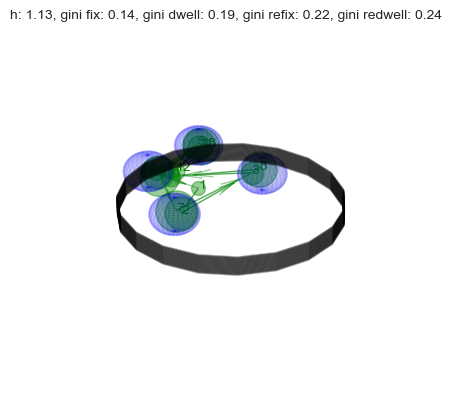

n valid trials 60
alloeye_51
- dataframe returned in 0.18849563598632812
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


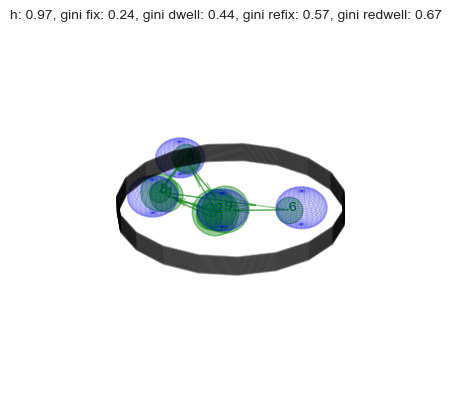

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


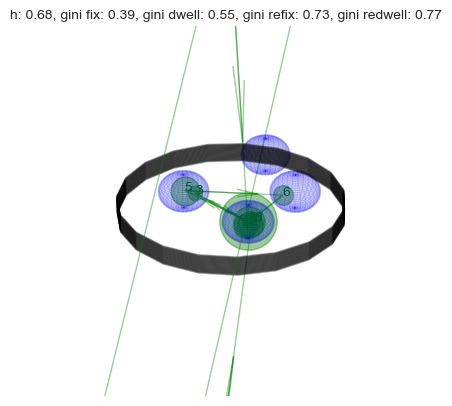

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


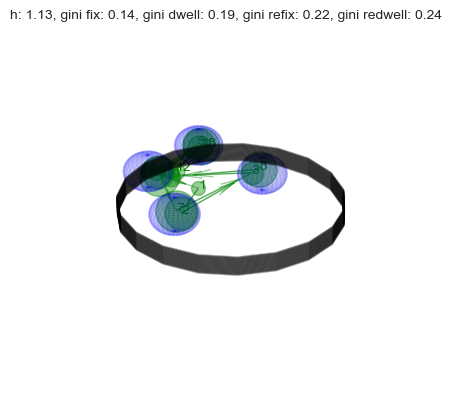

n valid trials 60
alloeye_52
- dataframe returned in 0.11668896675109863
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


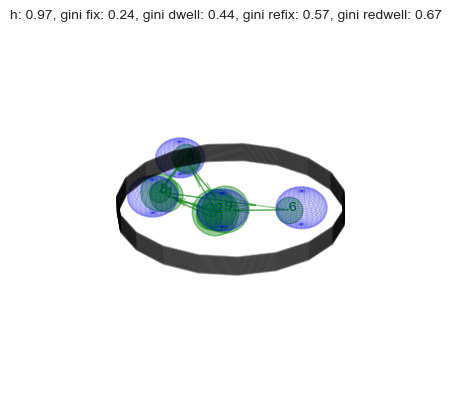

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


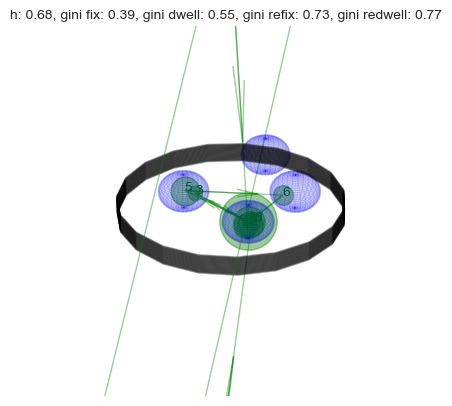

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


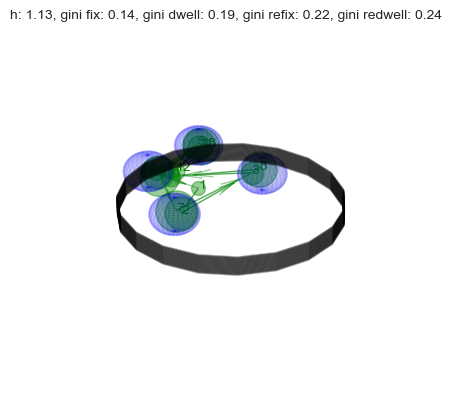

n valid trials 60
MCI *****************************************************************
alloeye_50
- dataframe returned in 0.11771273612976074
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


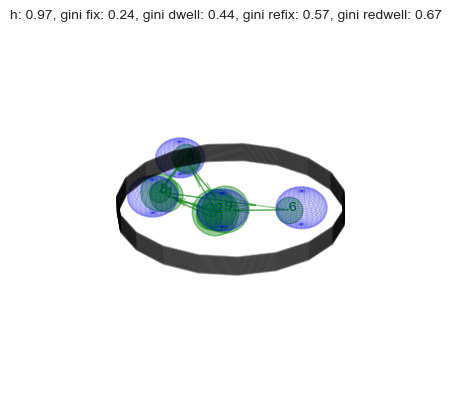

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


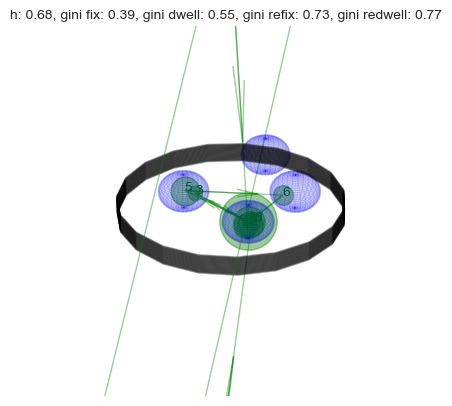

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


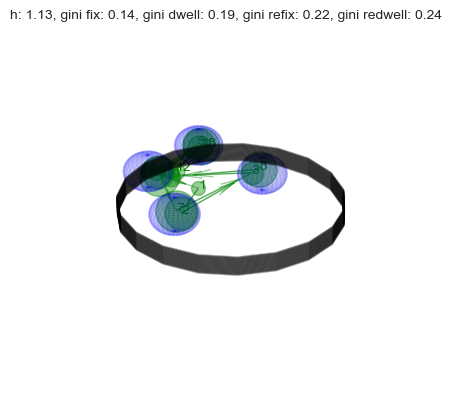

n valid trials 60
alloeye_51
- dataframe returned in 0.10967826843261719
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


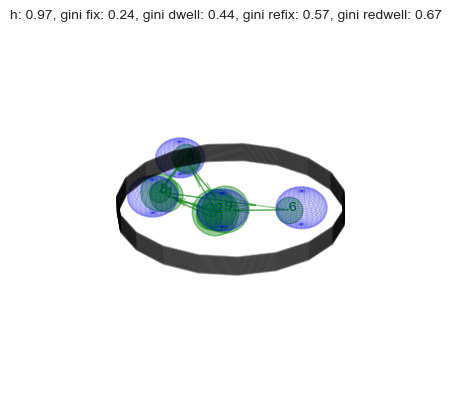

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


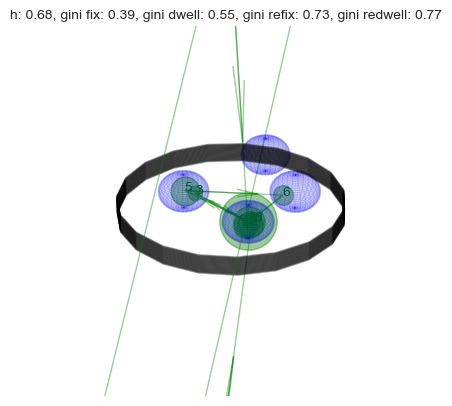

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


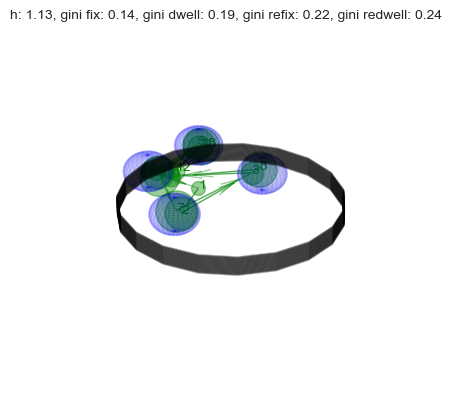

n valid trials 60
alloeye_52
- dataframe returned in 0.16655468940734863
alloeye_93p1_10_ret
p fix [0.3 0.2 0.3 0.1 0.1]
p dwell [0.24975157 0.1240477  0.50778403 0.0606161  0.0578006 ]
p refix [0.4 0.2 0.4 0.  0.  0. ]
p redwell [0.29457364 0.10325581 0.60217054 0.         0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


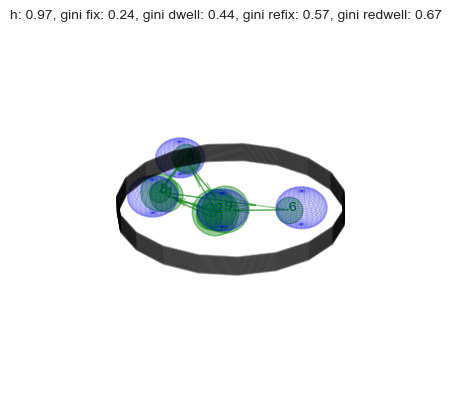

alloeye_93p1_11_ret
p fix [0.18181818 0.09090909 0.18181818 0.36363636 0.09090909 0.09090909
 0.        ]
p dwell [0.16348427 0.15457356 0.09838152 0.51682124 0.03036916 0.03637025
 0.        ]
p refix [0.2 0.  0.2 0.6 0.  0.  0.  0. ]
p redwell [0.17750981 0.         0.12142457 0.70106562 0.         0.
 0.         0.        ]
(-0.2449878, -0.2939857, 0.6346134)


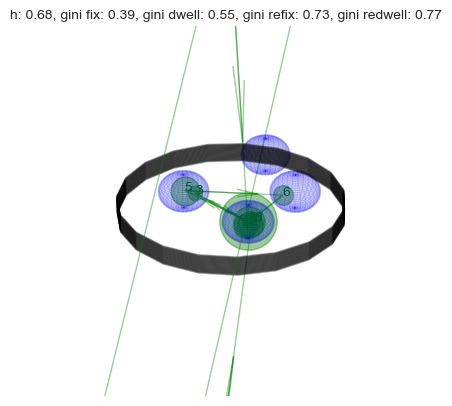

alloeye_93p1_12_ret
p fix [0.14285714 0.14285714 0.21428571 0.21428571 0.28571429]
p dwell [0.2499143  0.15563936 0.07422009 0.2500857  0.27014056]
p refix [0.11111111 0.11111111 0.22222222 0.22222222 0.33333333]
p redwell [0.20573159 0.15144455 0.07758621 0.22343896 0.3417987 ]
(-0.2449878, -0.2939857, 0.6346134)


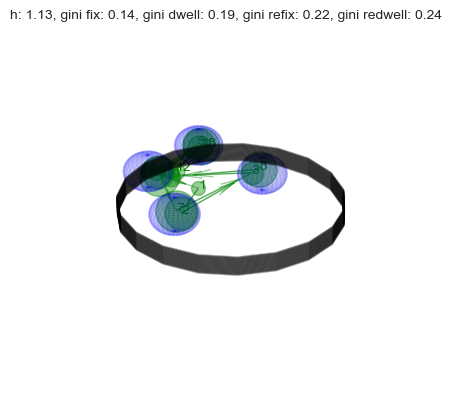

n valid trials 60


In [9]:
plt.close('all')

grouped_all_ps = []
for g in range(len(pid_groups)):
    g = 2
    print(group_names[g], '*****************************************************************')
    
    pids = pid_groups[g]
    n_pids = len(pids)
    av_ext_fix, av_refix_all, av_extfix_moved, av_extfix_selected = [], [], [], []
    plots_per_group = 1000
    plots_shown = 0
    n_pids = 3
    for p in range(n_pids):
        # p = 3
        print(pids[p])
        pid = pids[p]
        pid = 'alloeye_93'
        all_fixsac = fetch_fixations(pid, practice=True, suppress_print=True)

        all_fixsac = all_fixsac[all_fixsac.viewing_id.str.contains(viewing_type)]

        all_fix = all_fixsac[all_fixsac.fixation_or_saccade == 'fixation'].reset_index(drop=True).sort_values(by='start_time')
        all_trials = fetch_trials(pid, practice=[True, False], suppress_print=True)
        # print(all_trials.shape)
        trials_fix = np.unique(all_fix.trial_id)
        n_trials = len(trials_fix)
        n_valid_trials = n_trials

        # instantiate data arrays
        n_ext_fix = np.zeros([n_bins,])
        n_refix_all = np.zeros([n_bins,])
        n_extfix_moved = np.zeros([n_bins,])
        n_extfix_selected = np.zeros([n_bins,])
        # print(all_trials.head())
        n_trials = 10 if n_trials > 10 else n_trials
        for t in range(n_trials):
            # t = 15
            trial_id = trials_fix[t]
            trial = all_trials[all_trials.trial_id == trial_id].reset_index(drop=True)
            fixations = all_fix[all_fix.trial_id == trial_id].reset_index(drop=True).sort_values(by='start_time')
            # print("fixations", fixations.shape)
            # print("trial", trial_id)
            if len(trial) < 1:
                n_valid_trials -= 1
                continue
            if len(fixations) < 1:
                n_valid_trials -= 1
                continue
            # print("test post")
            # if plots_shown < plots_per_group:
            #     display(fixations.head(10).style)
            #     fixation_plot(fixations, trial=trial)
            #     plt.show()
            
            moved_object = trial.object_shifted[0]
            selected_object = trial.selected_object[0]

            for v in ['enc', 'ret']:
                viewing_id = f"{trial_id}_{v}"
                view_fix = fixations[fixations.viewing_id == viewing_id]
                if len(view_fix) < 2:
                    continue
                ext_fix = external_fixations(view_fix)

                if plots_shown < plots_per_group:
                    print(viewing_id)
                    # display(ext_fix.head(6).style)
                    prob_matrix, objects = transition_matrix(ext_fix, prob=True)
                    ht = transition_entropy_2(prob_matrix)
                    pi_n = stationary_prob(ext_fix, objects, prob_func=n_fix, adjust_missing_array_objects=True)
                    print('p fix', pi_n)
                    gn = gini(pi_n)
                    pi_d = stationary_prob(ext_fix, objects, prob_func=dwell_time, adjust_missing_array_objects=True)
                    gd = gini(pi_d)
                    print('p dwell', pi_d)
                    refix = refixations_only(ext_fix)
                    pi_n_re = stationary_prob(refix, objects, prob_func=n_fix, adjust_missing_array_objects=True)
                    gn_re = gini(pi_n_re)
                    pi_d_re = stationary_prob(refix, objects, prob_func=dwell_time, adjust_missing_array_objects=True)
                    gd_re = gini(pi_d_re)
                    print('p refix', pi_n_re)
                    print('p redwell', pi_d_re)
                    title = f'h: {ht:.2f}, gini fix: {gn:.2f}, gini dwell: {gd:.2f}, gini refix: {gn_re:.2f}, gini redwell: {gd_re:.2f}'
                    fixation_plot(ext_fix, trial=trial, title = title)
                    plt.show()
                    plots_shown += 1
                # normalise the time
                ext_fix.end_time -=  np.min(ext_fix.start_time)
                ext_fix.start_time -= np.min(ext_fix.start_time)

                # display(ext_fix.head(5).style)

                objects = []
                for _bin in range(n_bins):
                    # Filter DataFrame by time bin
                    df_bin = ext_fix[(ext_fix['start_time'] >= _bin*time_bin_size) & (ext_fix['start_time'] < (_bin+1)*time_bin_size)]
                    # display(df_bin.style)
                    # number of fixations
                    n_ext_fix[_bin] += df_bin.object.count()

                    # number of refixations overall
                    for obj in df_bin.object:
                        if np.isin([obj], objects):
                            n_refix_all[_bin] += 1
                        else:
                            objects.append(obj)

                    # number of refixations on moved object
                    df_bin_moved = df_bin[df_bin.object == moved_object]
                    n_extfix_moved[_bin] += df_bin_moved['object'].count()
    #                 if moved_object in objects:

    #                 else:
    #                     n_refix_moved[_bin] += np.max(0, df_bin_moved['object'].count() - 1)

                    # number of refixations on selected object
                    df_bin_selected = df_bin[df_bin.object == selected_object]
                    n_extfix_selected[_bin] += df_bin_selected['object'].count()
    #                 if selected_object in objects:

    #                 else:
    #                     n_refix_selected[_bin] += np.max(0, df_bin_selected['object'].count() - 1)
        print('n valid trials', n_valid_trials)    
        if n_valid_trials < 2:
            continue
            
        av_ext_fix.append(n_ext_fix / n_valid_trials)
        av_refix_all.append(n_refix_all / n_valid_trials)
        av_extfix_moved.append(n_extfix_moved / n_valid_trials)
        av_extfix_selected.append(n_extfix_selected / n_valid_trials)
    
    all_avs = [av_ext_fix, av_refix_all, av_extfix_moved, av_extfix_selected]
    grouped_all_ps.append(all_avs)
        

    

In [ ]:
grouped_all_ps[0][0]

In [ ]:
for g in range(len(pid_groups)):
    pids = pid_groups[g]
    all_ps = grouped_all_ps[g]
    labels = ['ext_fix', 'refix_all', 'refix_moved', 'refix_selected']
    n = len(pids)
    ax = plt.figure().add_subplot()
    colors = itertools.cycle(["r", "b", "g", "c", "m", "y"])
    error_alpha = 0.2
    for i in [0, 1, 2, 3]: 
        ps = all_ps[i]
        color = next(colors)
        # print(len(ps))
        means = np.nanmean(ps, axis=0)
        stds = np.nanstd(ps, axis=0)
        ses = stds / np.sqrt(n)
        uppers = means + ses
        lowers = means - ses
        # print(means)
        ax.plot(means, c=color, label=labels[i])
        # ax.plot(uppers, c=color, alpha=error_alpha)
        # ax.plot(lowers, c=color, alpha=error_alpha)
        ax.fill_between(np.arange(n_bins), uppers, lowers, alpha=0.3, color=color)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average number of')
        ax.set_title(group_names[g])
        ax.legend()
    plt.show()

In [ ]:
labels = ['ext_fix', 'refix_all', 'refix_moved', 'refix_selected']

error_alpha = 0.2
for i in [0, 1, 2, 3]: 
    ax = plt.figure().add_subplot()
    colors = itertools.cycle(["r", "b", "g", "c", "m"])
    for g in range(len(pid_groups)):
        pids = pid_groups[g]
        all_ps = grouped_all_ps[g]
        n = len(pids)
        ps = all_ps[i]
        color = next(colors)
        means = np.nanmean(ps, axis=0)
        stds = np.nanstd(ps, axis=0)
        print(means)
        ses = stds / np.sqrt(n)
        uppers = means + ses
        lowers = means - ses
        ax.plot(means, c=color, label=group_names[g])
        # ax.plot(uppers, c=color, alpha=error_alpha)
        # ax.plot(lowers, c=color, alpha=error_alpha)
        ax.fill_between(np.arange(n_bins), uppers, lowers, alpha=0.3, color=color)
    # Add labels and legend
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average number of')
    ax.set_title(labels[i])
    ax.legend()
    plt.show()
